In [ ]:
import warnings
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    silhouette_score,
)

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

plt.style.use("seaborn-v0_8-darkgrid")
az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC v5.22.0
Running on ArviZ v0.21.0


In [3]:
# Load the dataset
df = pd.read_csv("data/Income_Survey_Dataset.csv")

# --- Basic Data Cleaning & Feature Engineering ---
# Identify and replace placeholder values (like 99999996) with NaN
placeholder_value = 99999996
cols_with_placeholders = ["CONDMP", "RENTM"]  # Add others if identified
for col in cols_with_placeholders:
    if col in df.columns:
        df[col] = df[col].replace(placeholder_value, np.nan)

# Handle potential zero/negative incomes before log transform
# Add 1 to avoid log(0). Check if negative incomes exist and handle appropriately (e.g., treat as 0 or remove)
df["Total_income_log"] = np.log1p(df["Total_income"].clip(lower=0))

# Convert Gender (assuming 1=Male, 2=Female) to 0/1 for easier modeling
# Check unique values first to confirm coding
if "Gender" in df.columns and set(df["Gender"].unique()).issubset({1, 2}):
    df["Gender_binary"] = df["Gender"].apply(
        lambda x: 0 if x == 1 else (1 if x == 2 else x)
    )  # 0: Male, 1: Female
else:
    print("Warning: Gender column coding not as expected (1/2). Skipping binary conversion.")
    # Create a dummy if it doesn't exist or has unexpected values, for code flow
    if "Gender_binary" not in df.columns:
        df["Gender_binary"] = np.random.randint(0, 2, size=len(df))


# Convert Immigrant (assuming 1=Yes, 2=No) to 1/0
if "Immigrant" in df.columns and set(df["Immigrant"].unique()).issubset({1, 2}):
    df["Immigrant_binary"] = df["Immigrant"].apply(
        lambda x: 1 if x == 1 else (0 if x == 2 else x)
    )  # 1: Immigrant, 0: Non-immigrant
else:
    print("Warning: Immigrant column coding not as expected (1/2). Skipping binary conversion.")
    if "Immigrant_binary" not in df.columns:
        df["Immigrant_binary"] = np.random.randint(0, 2, size=len(df))


# Display basic info and check the new columns
print("\n--- Data Info After Initial Preprocessing ---")
df.info()
print("\n--- Descriptive Statistics (Log Income) ---")
print(df["Total_income_log"].describe())
print("\n--- Value Counts (Binary Gender) ---")
if "Gender_binary" in df.columns:
    print(df["Gender_binary"].value_counts(dropna=False))
print("\n--- Value Counts (Binary Immigrant) ---")
if "Immigrant_binary" in df.columns:
    print(df["Immigrant_binary"].value_counts(dropna=False))

# Check for NaNs introduced or pre-existing
print("\n--- Missing Values per Column (Top 10) ---")
print(df.isnull().sum().sort_values(ascending=False).head(10))

# --- Data Subsampling for PyMC (Optional but recommended for large datasets) ---
# Using a smaller subset for faster MCMC sampling demonstration
sample_size = min(5000, len(df))  # Use up to 5000 samples or full data if smaller
df_subset = df.sample(n=sample_size, random_state=42)
print(f"\n--- Using subset of {sample_size} samples for PyMC analysis ---")


--- Data Info After Initial Preprocessing ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72643 entries, 0 to 72642
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PersonID           72643 non-null  int64  
 1   Weight             72643 non-null  float64
 2   Province           72643 non-null  int64  
 3   MBMREGP            72643 non-null  int64  
 4   Age_gap            72643 non-null  int64  
 5   Gender             72643 non-null  int64  
 6   Marital_status     72643 non-null  int64  
 7   Highschool         72643 non-null  int64  
 8   Highest_edu        72643 non-null  int64  
 9   Work_ref           72643 non-null  int64  
 10  Work_yearly        72643 non-null  int64  
 11  Emp_week_ref       72643 non-null  int64  
 12  Total_hour_ref     72643 non-null  int64  
 13  paid_emp_ref       72643 non-null  int64  
 14  self_emp_ref       72643 non-null  int64  
 15  Immigrant          7264


--- Data shape for PyMC Regression: (5000, 7) ---

--- Starting PyMC Sampling (Bayesian Regression) ---


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, beta_Age, beta_Education, beta_Gender, beta_Immigrant, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


--- PyMC Sampling Complete ---

--- Bayesian Regression Results ---
Max R-hat: <xarray.Dataset> Size: 48B
Dimensions:         ()
Data variables:
    Intercept       float64 8B 1.0
    beta_Age        float64 8B 1.0
    beta_Education  float64 8B 0.9992
    beta_Gender     float64 8B 1.001
    beta_Immigrant  float64 8B 1.001
    sigma           float64 8B 1.0

Posterior Summary:
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       11.376  0.020  11.340   11.414        0.0    0.001    1743.0   
beta_Age        -0.125  0.013  -0.152   -0.103        0.0    0.000    2053.0   
beta_Education   0.035  0.013   0.009    0.062        0.0    0.000    2041.0   
beta_Gender     -0.037  0.023  -0.079    0.004        0.0    0.001    2090.0   
beta_Immigrant   0.017  0.023  -0.029    0.058        0.0    0.001    2250.0   
sigma            0.815  0.008   0.799    0.829        0.0    0.000    2316.0   

                ess_tail  r_hat  
Intercept         1324.

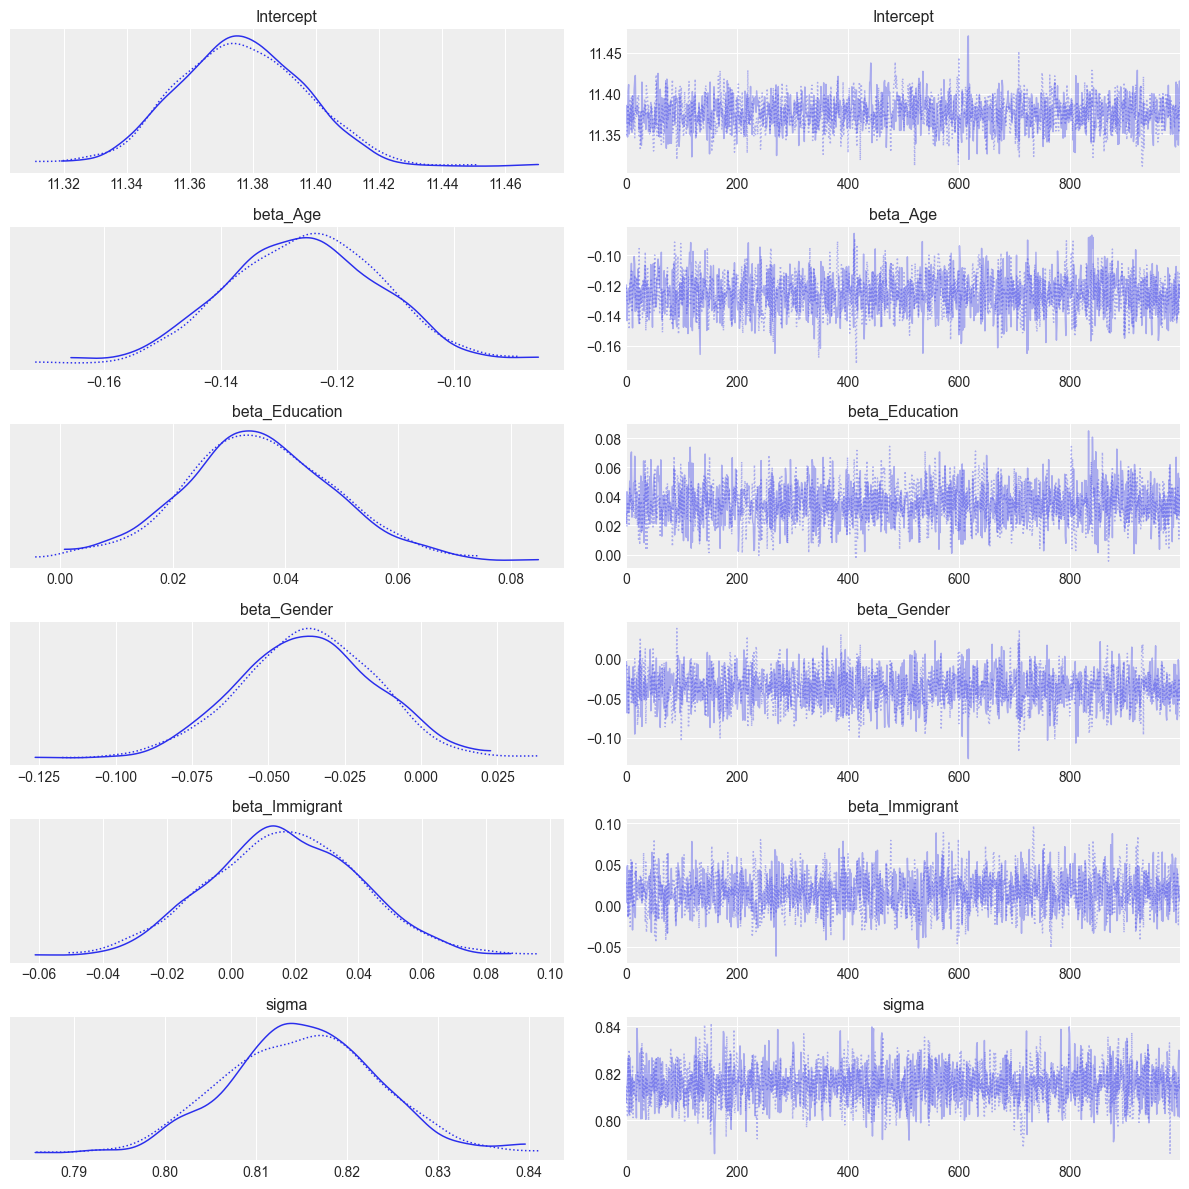

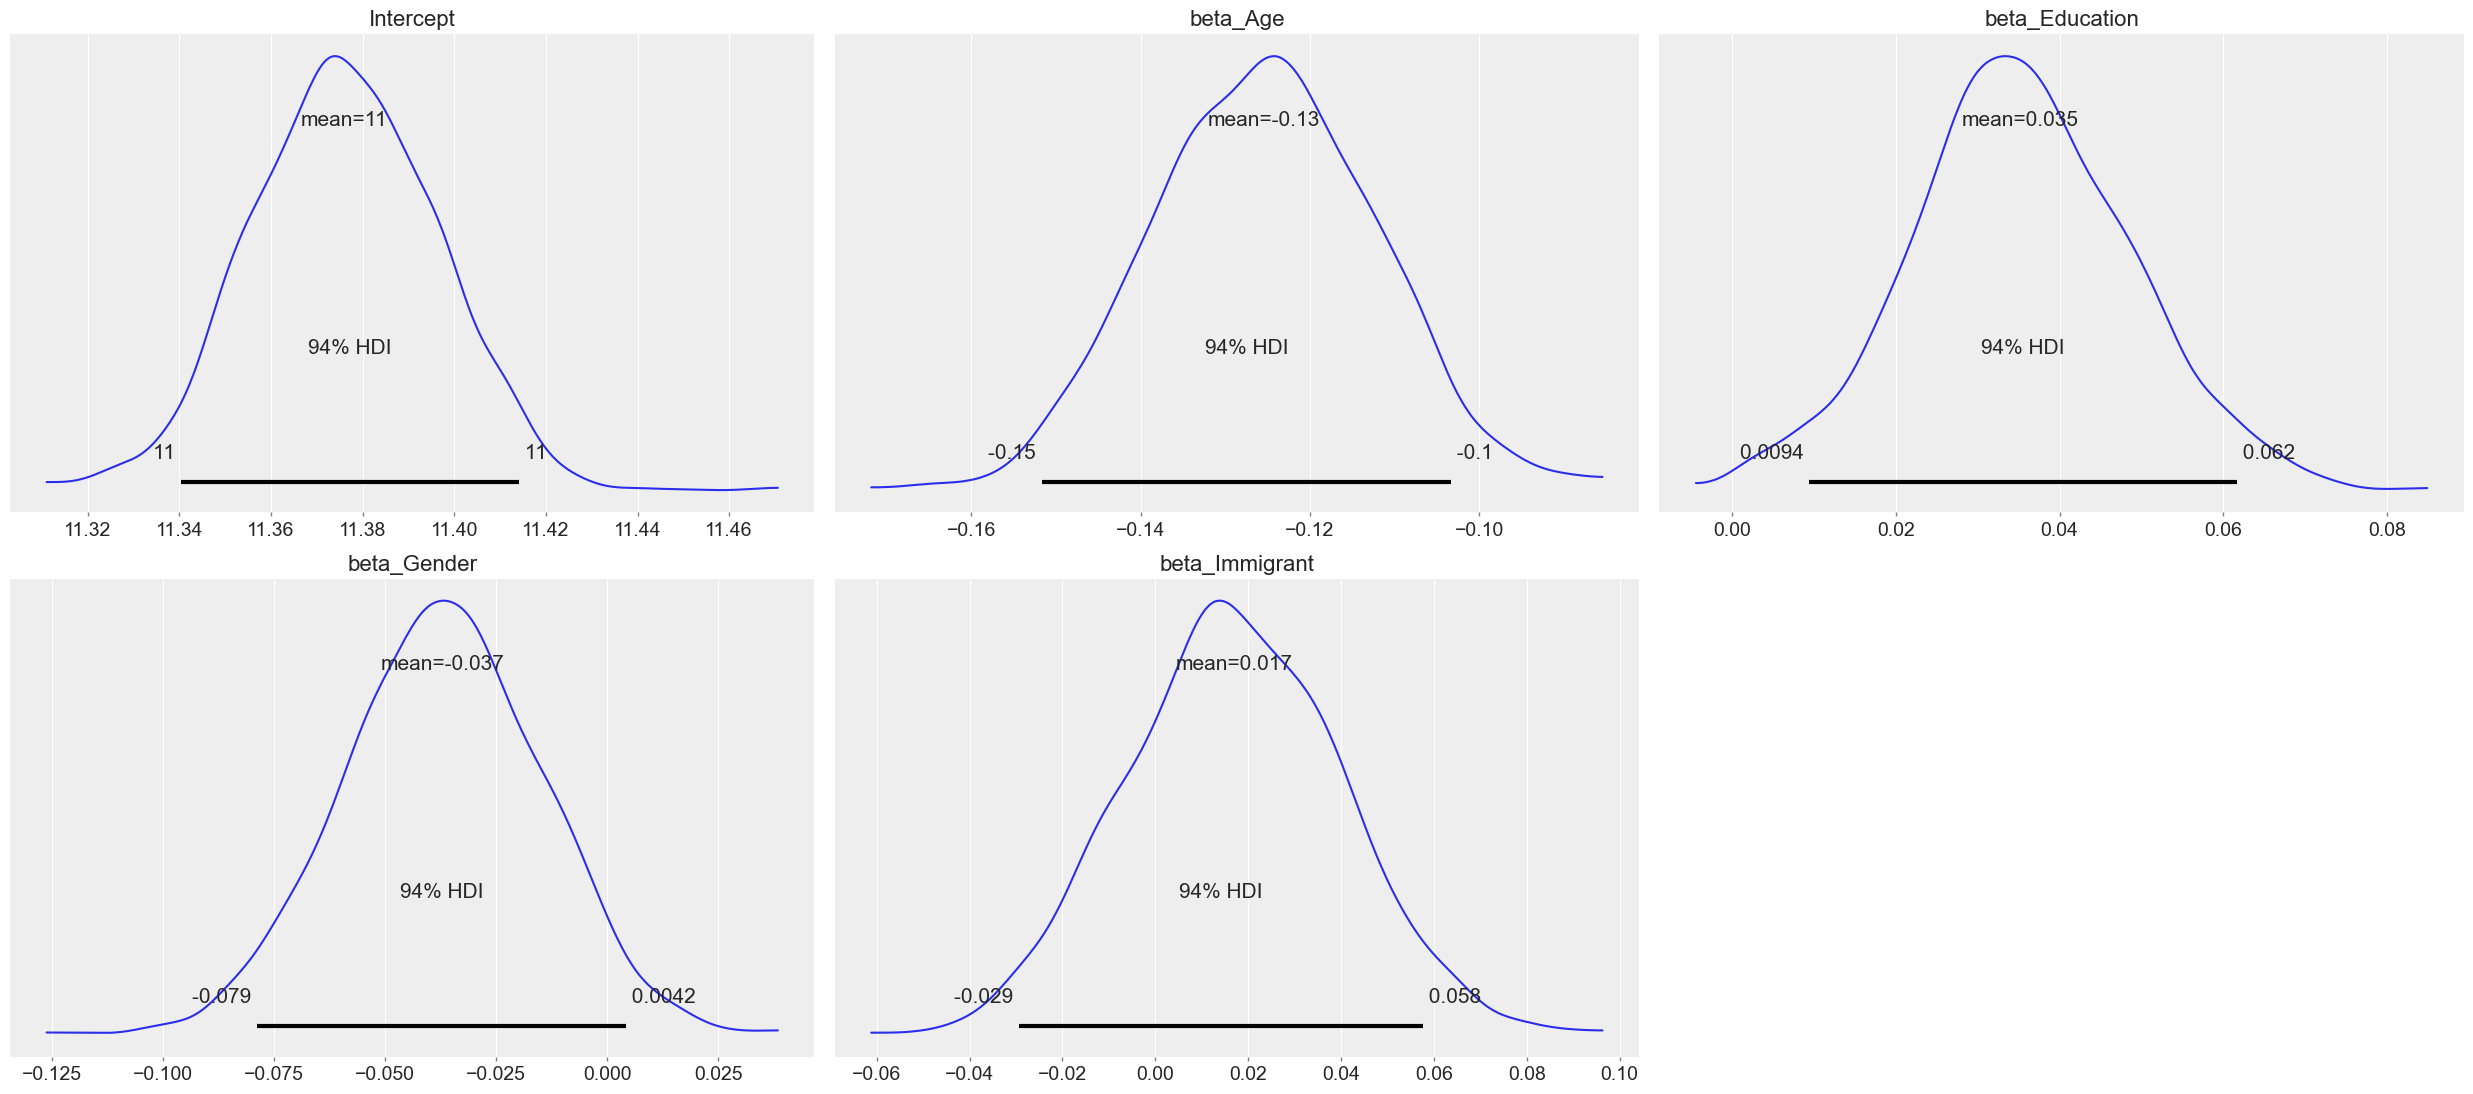

In [4]:
# --- Prepare Data for PyMC Regression ---
reg_features = ["Age_gap", "Highest_edu", "Gender_binary", "Immigrant_binary"]
target = "Total_income_log"

# Drop rows with NaNs in selected columns for this specific analysis
df_reg = df_subset[[target] + reg_features].dropna()

# Scale numerical predictors (Age_gap, Highest_edu treated as numerical/ordinal)
scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(df_reg[["Age_gap", "Highest_edu"]])
df_reg[["Age_gap_scaled", "Highest_edu_scaled"]] = X_reg_scaled

y_reg = df_reg[target].values
X_reg_age = df_reg["Age_gap_scaled"].values
X_reg_edu = df_reg["Highest_edu_scaled"].values
X_reg_gender = df_reg["Gender_binary"].values  # Already 0/1
X_reg_immigrant = df_reg["Immigrant_binary"].values  # Already 0/1

print(f"\n--- Data shape for PyMC Regression: {df_reg.shape} ---")

# --- Define PyMC Model ---
with pm.Model() as income_model:
    # --- Priors ---
    # Intercept: Centered around the mean of log income, weakly informative std dev
    intercept = pm.Normal("Intercept", mu=y_reg.mean(), sigma=5)

    # Coefficients for scaled predictors: Weakly informative, centered at 0
    beta_age = pm.Normal("beta_Age", mu=0, sigma=2)
    beta_edu = pm.Normal("beta_Education", mu=0, sigma=2)

    # Coefficients for binary predictors: Weakly informative, centered at 0
    beta_gender = pm.Normal("beta_Gender", mu=0, sigma=2)
    beta_immigrant = pm.Normal("beta_Immigrant", mu=0, sigma=2)

    # Error term standard deviation: Half-Cauchy is a common choice
    sigma = pm.HalfCauchy("sigma", beta=2)

    # --- Linear Model Equation ---
    mu = (
        intercept
        + beta_age * X_reg_age
        + beta_edu * X_reg_edu
        + beta_gender * X_reg_gender
        + beta_immigrant * X_reg_immigrant
    )

    # --- Likelihood ---
    # Normal distribution for the log-transformed income
    income_like = pm.Normal("income_like", mu=mu, sigma=sigma, observed=y_reg)

# --- Sample from the Posterior ---
print("\n--- Starting PyMC Sampling (Bayesian Regression) ---")
# Using fewer draws/tuning steps for faster demonstration
with income_model:
    idata_income = pm.sample(
        draws=1000, tune=1000, chains=2, cores=1, random_seed=42, progressbar=True
    )  # Reduced chains/cores for compatibility
print("--- PyMC Sampling Complete ---")

# --- Analyze Results ---
print("\n--- Bayesian Regression Results ---")

# Check convergence diagnostics (R-hat)
rhats = az.rhat(idata_income)
print("Max R-hat:", az.rhat(idata_income).max())  # Should be close to 1.0

# Print posterior summary statistics
print("\nPosterior Summary:")
summary = az.summary(
    idata_income,
    var_names=["Intercept", "beta_Age", "beta_Education", "beta_Gender", "beta_Immigrant", "sigma"],
)
print(summary)

# Plot posterior distributions and trace plots
print("\nPlotting Posteriors and Traces...")
az.plot_trace(
    idata_income,
    var_names=["Intercept", "beta_Age", "beta_Education", "beta_Gender", "beta_Immigrant", "sigma"],
)
plt.tight_layout()
plt.show()

az.plot_posterior(
    idata_income,
    var_names=["Intercept", "beta_Age", "beta_Education", "beta_Gender", "beta_Immigrant"],
)
plt.tight_layout()
plt.show()

# Interpretation:
# - Look at the mean/median of the posterior distributions for coefficients (beta_*).
# - If the 94% HPD (Highest Posterior Density interval) excludes 0, the predictor is likely statistically significant.
# - beta_Age: Effect of one standard deviation increase in Age on log-income.
# - beta_Education: Effect of one standard deviation increase in Highest Education level on log-income.
# - beta_Gender: Difference in log-income for Female (1) compared to Male (0).
# - beta_Immigrant: Difference in log-income for Immigrant (1) compared to Non-immigrant (0).
# - sigma: Estimated standard deviation of the residuals (error term).


--- Data shape for Classification (Train): (50850, 3) ---
--- Data shape for Classification (Test): (21793, 3) ---

--- Gaussian Naive Bayes Classification Results ---
Accuracy: 0.4979

Classification Report:
                   precision    recall  f1-score   support

Non-immigrant (0)       0.50      0.60      0.54     10930
    Immigrant (1)       0.50      0.40      0.44     10863

         accuracy                           0.50     21793
        macro avg       0.50      0.50      0.49     21793
     weighted avg       0.50      0.50      0.49     21793


Confusion Matrix:
[[6551 4379]
 [6564 4299]]


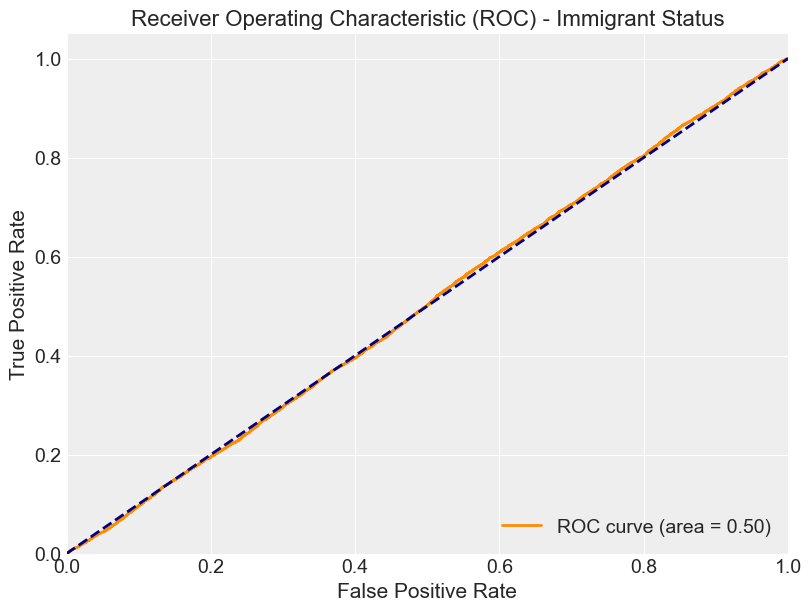

In [5]:
# --- Prepare Data for Classification ---
class_features = ["Age_gap", "Highest_edu", "Total_income_log"]
class_target = "Immigrant_binary"

# Use the full dataset for this analysis (or df_subset if preferred)
# Drop rows with NaNs in selected columns
df_class = df[[class_target] + class_features].dropna()

X_class = df_class[class_features]
y_class = df_class[class_target]

# Split data into training and testing sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
)

# Scale features (important for Gaussian assumption and distance-based metrics if used later)
scaler_class = StandardScaler()
X_train_c_scaled = scaler_class.fit_transform(X_train_c)
X_test_c_scaled = scaler_class.transform(X_test_c)

print(f"\n--- Data shape for Classification (Train): {X_train_c_scaled.shape} ---")
print(f"--- Data shape for Classification (Test): {X_test_c_scaled.shape} ---")

# --- Train Gaussian Naive Bayes Model ---
gnb = GaussianNB()
gnb.fit(X_train_c_scaled, y_train_c)

# --- Evaluate the Model ---
y_pred_c = gnb.predict(X_test_c_scaled)
y_prob_c = gnb.predict_proba(X_test_c_scaled)[:, 1]  # Probability of class 1 (Immigrant)

print("\n--- Gaussian Naive Bayes Classification Results ---")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c):.4f}")
print("\nClassification Report:")
print(
    classification_report(y_test_c, y_pred_c, target_names=["Non-immigrant (0)", "Immigrant (1)"])
)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_c, y_pred_c))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_c, y_prob_c)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) - Immigrant Status")
plt.legend(loc="lower right")
plt.show()

# Interpretation:
# - GaussianNB provides probabilities (predict_proba) for each class.
# - The ROC curve shows the trade-off between true positive rate and false positive rate at various probability thresholds.
# - AUC score gives a single measure of separability.
# - Classification report provides precision, recall, F1-score per class.


--- Data shape for Clustering: (72643, 4) ---

--- Finding Optimal Number of Clusters (GMM) ---
  k=2, BIC: 721106.81, AIC: 720840.21
  k=3, BIC: 669384.65, AIC: 668980.14
  k=4, BIC: 478762.21, AIC: 478219.81
  k=5, BIC: 434998.88, AIC: 434318.58
  k=6, BIC: 424225.66, AIC: 423407.46
  k=7, BIC: 328256.82, AIC: 327300.71
  k=8, BIC: 325099.21, AIC: 324005.21


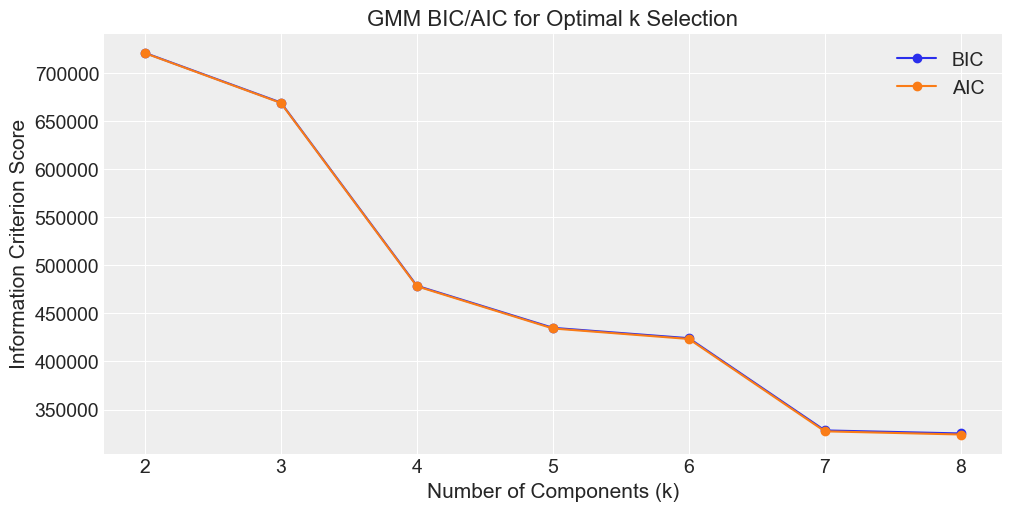


--- Optimal number of clusters (based on min BIC): 8 ---

--- GMM Clustering Results ---
Number of clusters found: 8
Silhouette Score: 0.1827

Cluster Profiles (Mean Values):
           Age_gap  Highest_edu  Total_income_log  Family_mem
Cluster                                                      
0         8.250055     2.892802         11.830889    4.000000
1         2.030263     6.000000         11.547030    4.159816
2        11.546821     2.616606         10.577606    1.000000
3         9.273807     2.814603         11.632787    3.000000
4         7.837176     2.740874         11.790687    5.342699
5         9.375486     9.000000         11.033608    2.337743
6        12.040785     2.676052         11.323612    2.000000
7         9.250000     3.305556          0.000000    3.000000

Cluster Sizes:
Cluster
6    23121
1    12821
2    11779
3     9094
0     9058
4     4164
5     2570
7       36
Name: count, dtype: int64


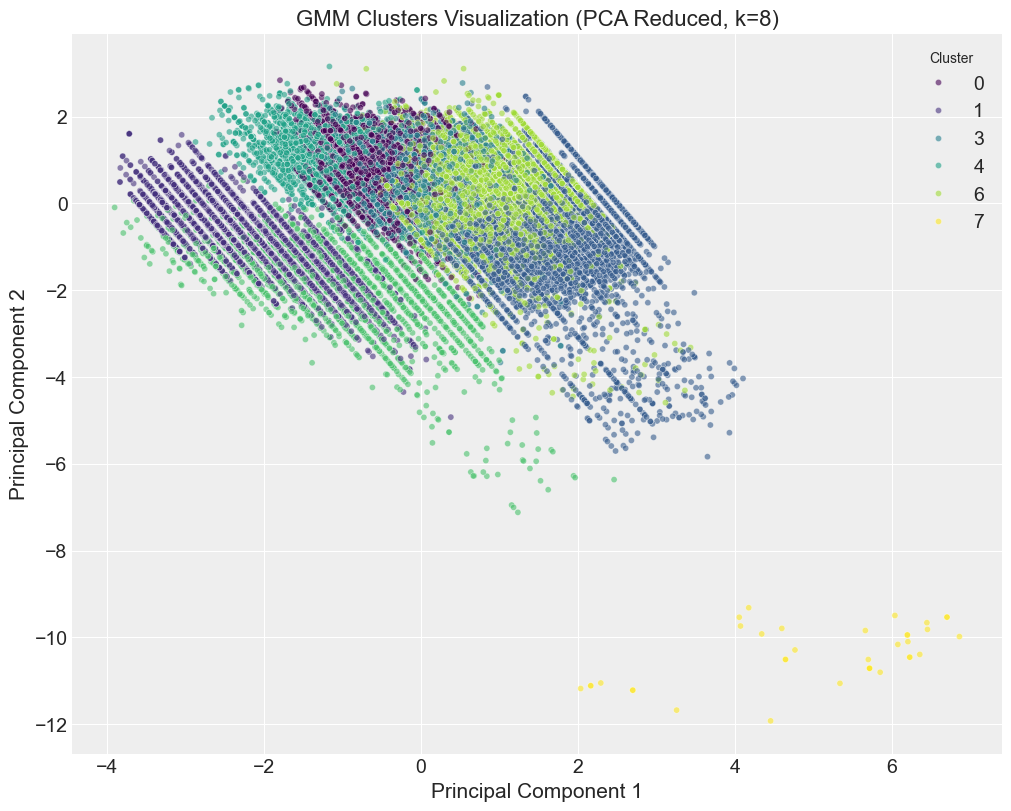

In [6]:
# --- Prepare Data for Clustering ---
clust_features = ["Age_gap", "Highest_edu", "Total_income_log", "Family_mem"]

# Use the full dataset (or df_subset)
# Drop rows with NaNs in selected columns
df_clust = df[clust_features].dropna()

# Scale features (very important for GMM)
scaler_clust = StandardScaler()
X_clust_scaled = scaler_clust.fit_transform(df_clust)

print(f"\n--- Data shape for Clustering: {X_clust_scaled.shape} ---")

# --- Determine Optimal Number of Clusters (k) using BIC ---
n_components_range = range(2, 9)  # Test k from 2 to 8
bic_scores = []
aic_scores = []

print("\n--- Finding Optimal Number of Clusters (GMM) ---")
for n_components in n_components_range:
    gmm = GaussianMixture(
        n_components=n_components, covariance_type="full", random_state=42, n_init=5
    )  # n_init > 1 recommended
    gmm.fit(X_clust_scaled)
    bic_scores.append(gmm.bic(X_clust_scaled))
    aic_scores.append(gmm.aic(X_clust_scaled))
    print(f"  k={n_components}, BIC: {bic_scores[-1]:.2f}, AIC: {aic_scores[-1]:.2f}")


# Plot BIC/AIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_scores, marker="o", label="BIC")
plt.plot(n_components_range, aic_scores, marker="o", label="AIC")
plt.xlabel("Number of Components (k)")
plt.ylabel("Information Criterion Score")
plt.title("GMM BIC/AIC for Optimal k Selection")
plt.legend()
plt.xticks(n_components_range)
plt.show()

# Choose k based on the "elbow" or minimum BIC/AIC (often BIC is preferred for model selection)
optimal_k = n_components_range[np.argmin(bic_scores)]
print(f"\n--- Optimal number of clusters (based on min BIC): {optimal_k} ---")

# --- Fit Final GMM with Optimal k ---
final_gmm = GaussianMixture(
    n_components=optimal_k, covariance_type="full", random_state=42, n_init=10
)
final_gmm.fit(X_clust_scaled)

# Assign cluster labels and probabilities
cluster_labels = final_gmm.predict(X_clust_scaled)
cluster_probs = final_gmm.predict_proba(X_clust_scaled)

df_clust["Cluster"] = cluster_labels
df_clust["Cluster_Prob"] = np.max(cluster_probs, axis=1)  # Probability of assigned cluster

# --- Analyze the Clusters ---
print("\n--- GMM Clustering Results ---")
print(f"Number of clusters found: {optimal_k}")

# Calculate Silhouette Score (optional metric, higher is better separation)
# Note: Silhouette score prefers convex clusters, GMM can model non-convex ones
try:
    silhouette_avg = silhouette_score(X_clust_scaled, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")
except ValueError as e:
    print(f"Could not calculate Silhouette Score: {e}")  # May fail if only 1 cluster found

# Profile the clusters by examining the means of the original (unscaled) features
cluster_profile = df_clust.groupby("Cluster")[clust_features].mean()
print("\nCluster Profiles (Mean Values):")
print(cluster_profile)

# Add cluster sizes
cluster_profile["Size"] = df_clust["Cluster"].value_counts()
print("\nCluster Sizes:")
print(df_clust["Cluster"].value_counts())

# Visualize clusters (using PCA for dimensionality reduction to 2D)
pca = PCA(n_components=2, random_state=42)
X_clust_pca = pca.fit_transform(X_clust_scaled)
df_clust["PCA1"] = X_clust_pca[:, 0]
df_clust["PCA2"] = X_clust_pca[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_clust, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", alpha=0.6, s=20
)
plt.title(f"GMM Clusters Visualization (PCA Reduced, k={optimal_k})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Interpretation:
# - GMM assigns each point a probability of belonging to each cluster.
# - BIC/AIC helps select a suitable number of components (clusters).
# - Cluster profiles (means/medians of features per cluster) help understand the characteristics of each group.
# - Visualization (e.g., PCA plot) gives a visual sense of cluster separation.